<a href="https://colab.research.google.com/github/RatneshRawat25/ai-ml-dl/blob/main/lung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')


In [ ]:
from zipfile import ZipFile

data_path = '/content/drive/MyDrive/lung_colon_image_set.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')


The data set has been extracted.


In [ ]:
path = '/content/lung_image_sets'
classes = os.listdir(path)
classes


['lung_scc', 'lung_aca', 'lung_n']

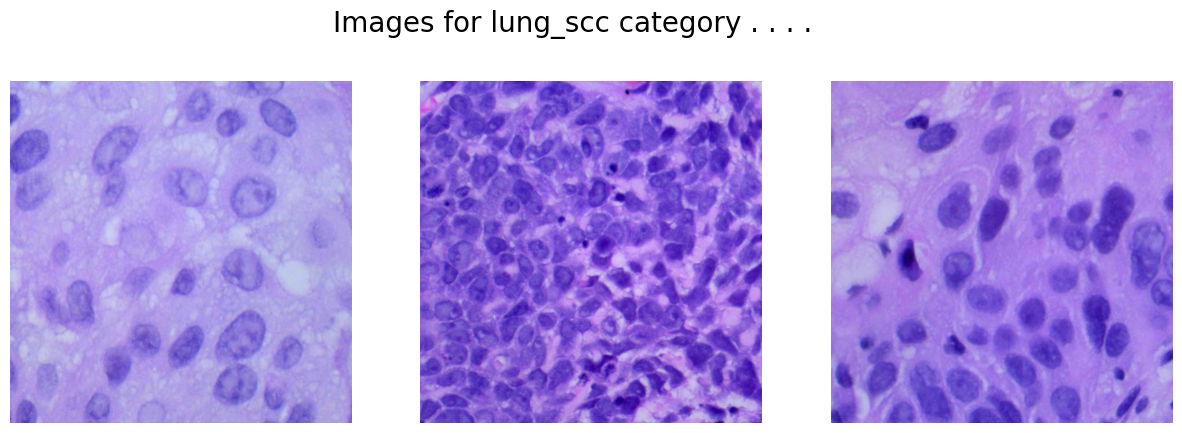

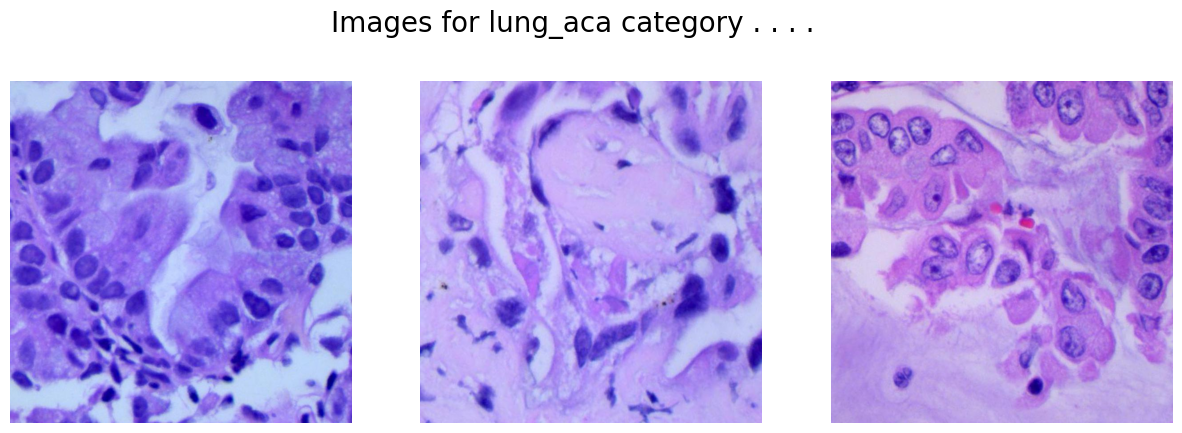

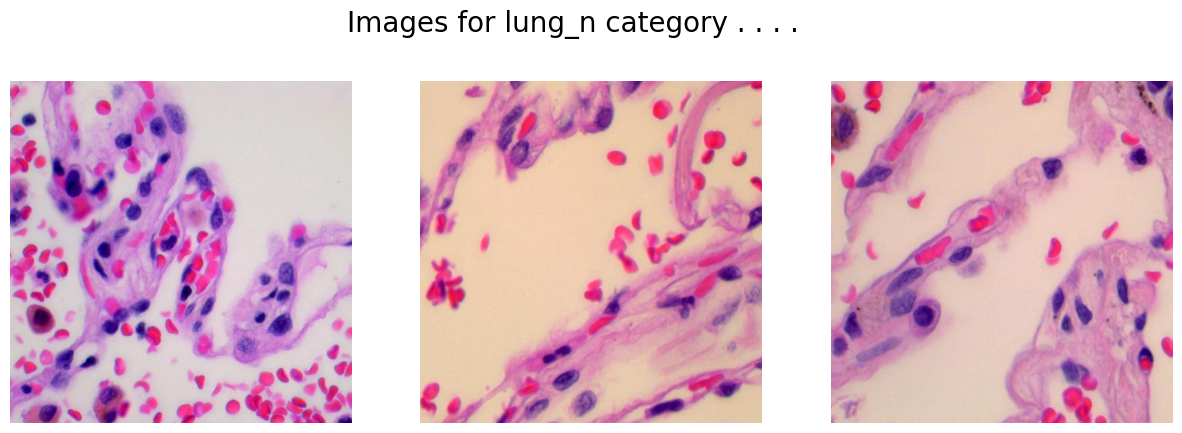

In [ ]:
path = '/content/lung_image_sets'

for cat in classes:
	image_dir = f'{path}/{cat}'
	images = os.listdir(image_dir)

	fig, ax = plt.subplots(1, 3, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

	for i in range(3):
		k = np.random.randint(0, len(images))
		img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
		ax[i].imshow(img)
		ax[i].axis('off')
	plt.show()


In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64


In [ ]:
X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

for image in images:
	img = cv2.imread(image)

	X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
	Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y,
												test_size = SPLIT,
												random_state = 2022)
print(X_train.shape, X_val.shape)


(4000, 256, 256, 3) (1000, 256, 256, 3)


In [ ]:
model = keras.models.Sequential([
	layers.Conv2D(filters=32,
				kernel_size=(5, 5),
				activation='relu',
				input_shape=(IMG_SIZE,
							IMG_SIZE,
							3),
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=64,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Conv2D(filters=128,
				kernel_size=(3, 3),
				activation='relu',
				padding='same'),
	layers.MaxPooling2D(2, 2),

	layers.Flatten(),
	layers.Dense(256, activation='relu'),
	layers.BatchNormalization(),
	layers.Dense(128, activation='relu'),
	layers.Dropout(0.3),
	layers.BatchNormalization(),
	layers.Dense(3, activation='softmax')
])


In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 128)       0

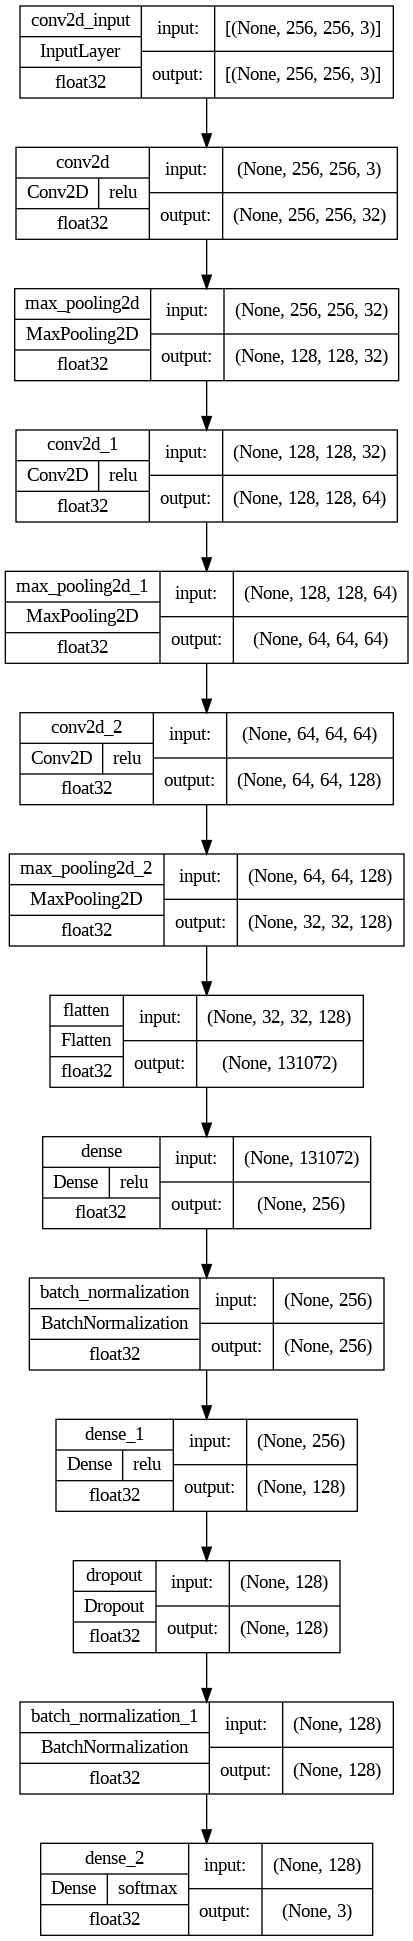

In [ ]:
keras.utils.plot_model(
	model,
	show_shapes = True,
	show_dtype = True,
	show_layer_activations = True
)


In [ ]:
model.compile(
	optimizer = 'adam',
	loss = 'categorical_crossentropy',
	metrics = ['accuracy']
)


In [ ]:
# Import necessary libraries
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pandas as pd
from sklearn import metrics
import numpy as np

# Define the custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\nValidation accuracy has reached 90%, stopping further training.')
            self.model.stop_training = True

# Define the EarlyStopping callback
es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

# Define the ReduceLROnPlateau callback
lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

# Load or create your dataset
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

# Normalize the dataset
x_train = x_train / 255.0
x_val = x_val / 255.0

# One-hot encode the labels
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_val = tf.keras.utils.to_categorical(y_val, 10)

# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set batch size and number of epochs
BATCH_SIZE = 32
EPOCHS = 50

# Train the model with the callbacks
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[es, lr, myCallback()])

# Convert the history to a DataFrame
history_df = pd.DataFrame(history.history)
print(history_df)

# Predict the labels for the validation set
y_pred = model.predict(x_val)
y_val_labels = np.argmax(y_val, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute and print the confusion matrix
conf_matrix = metrics.confusion_matrix(y_val_labels, y_pred_labels)
print('Confusion Matrix:')
print(conf_matrix)

# Print the classification report
target_names = [str(i) for i in range(10)]
class_report = metrics.classification_report(y_val_labels, y_pred_labels,
                                             target_names=target_names)
print('Classification Report:')
print(class_report)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1870/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8599 - loss: 0.4840
Validation accuracy has reached 90%, stopping further training.
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.8601 - loss: 0.4834 - val_accuracy: 0.9573 - val_loss: 0.1433 - learning_rate: 0.0010
   accuracy      loss  val_accuracy  val_loss  learning_rate
0     0.914  0.295963        0.9573  0.143295          0.001
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
[[ 963    0    2    2    0    4    6    2    1    0]
 [   0 1124    3    2    0    1    2    1    2    0]
 [   5    3  988    4    9    0    4    9    9    1]
 [   1    0   13  975    0    7    0   10    3    1]
 [   1    0    4    2  937    1    7    6    4   20]
 [   4    1    0   19    3  847    7    0    5    6]
 [   7    3    1    2    3   12  928    1    1    0]
 [   0    7   12    7    1    1    0  992    0    8]
 [   3    5    8   37    7   14    6   12  878    4]
 [   4    9    1   14   22    9    0    9    0